In [1]:
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt
from tqdm import tqdm

/khalid/k024/bioc1809/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.spatial import cKDTree

def MLS_surface(points, box, radius=30, quad=True, sigma=None):
    """
    Build a moving least squares evaluator for z(x,y) using periodic distances in x,y.
    points : (N,3) phosphate coords (can be unwrapped; we wrap to the box)
    box    : simulation box (Å), only box[0], box[1] used
    radius : neighbor radius (Å). If None, picked from data.
    quad   : quadratic (a + bx + cy + d x^2 + e xy + f y^2) if True, else plane.
    sigma  : weight length (Å). If None, set to radius/2.

    Returns: callable surface(xq, yq) -> z.
    """

    
    Lx, Ly = float(box[0]), float(box[1])
    xy = points[:, :2] % np.array([Lx, Ly])
    z  = points[:, 2].astype(float)

    # Build 3x3 tiled KD-tree so neighbor search is periodic
    shifts = np.array([(i*Lx, j*Ly) for i in (-1,0,1) for j in (-1,0,1)], float)
    tiles  = (xy[None, :, :] + shifts[:, None, :]).reshape(-1, 2)
    zt     = np.tile(z, 9)
    tree   = cKDTree(tiles)

    # Choose a sensible default radius from typical spacing
    if radius is None:
        # use 6-NN distance (skip self) as a characteristic spacing
        d6, _ = tree.query(xy, k=6)
        mean_nn = np.mean(d6[:, 1])
        radius  = 1.5 * mean_nn if np.isfinite(mean_nn) and mean_nn > 0 else min(Lx, Ly) / 6.0

    if sigma is None:
        sigma = radius / 2.0
    sig2 = (sigma * sigma)

    # Precompute basis selector for speed
    if quad:
        # a, bx, cy, dxx, exy, fyy
        def Gmat(dx, dy):
            return np.column_stack([np.ones_like(dx), dx, dy, dx*dx, dx*dy, dy*dy])
    else:
        # a, bx, cy
        def Gmat(dx, dy):
            return np.column_stack([np.ones_like(dx), dx, dy])

    def surface(xq, yq):
        X = (np.asarray(xq, dtype=float) % Lx)
        Y = (np.asarray(yq, dtype=float) % Ly)
        out = np.empty(np.broadcast(X, Y).shape, dtype=float)

        # Iterate over query points; ensure we assign a scalar each time
        for idx in np.ndindex(out.shape):
            x0, y0 = X[idx], Y[idx]

            # periodic neighbor search via tiled KD-tree
            ids = tree.query_ball_point([x0, y0], r=radius)
            nbr_xy = tiles[ids]
            nbr_z  = zt[ids]

            # local coords (centered at query point)
            dx = nbr_xy[:, 0] - x0
            dy = nbr_xy[:, 1] - y0

            # Gaussian weights
            w = np.exp(-(dx*dx + dy*dy) / (2.0*sig2)) + 1e-12

            # Weighted least squares
            G = Gmat(dx, dy)
            # use 1D b so lstsq returns a 1D coef
            W = np.sqrt(w)
            A = (W[:, None] * G)
            b = W * nbr_z
            coef, *_ = np.linalg.lstsq(A, b, rcond=None)
            coef = np.asarray(coef).ravel()   # ensure 1-D

            # Prediction at the center (dx=0, dy=0) is simply the constant term
            out[idx] = float(coef[0])

        return out

    return surface

##### Define MDAnalysis universe
from trajectory (xtc) and topology (gro) files

In [6]:
trajectory = '../cg_sims/run_01/prod.xtc'
topology = '../cg_sims/run_01/npt.gro'

u = mda.Universe(topology, trajectory)

/khalid/k024/bioc1809/miniconda3/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/khalid/k024/bioc1809/miniconda3/envs/mda/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


##### 3) Use MDAnalysis leaflet finder 
to obtain atom groups for the phosphate beads in upper and lower leaflets of the membrane

In [ ]:
from MDAnalysis.analysis.leaflet import LeafletFinder


# Select phosphate beads and detect leaflets
po4 = u.select_atoms("name PO4")
lf  = LeafletFinder(u, po4, cutoff=12.0, pbc=True)

upper_leaflet = lf.groups(0)
lower_leaflet = lf.groups(1)

224 214


/tmp/ipykernel_413002/1228894767.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


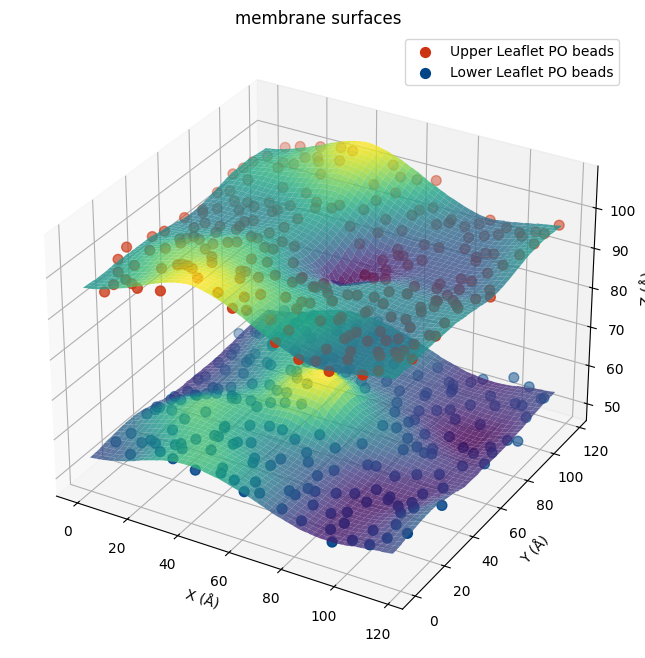

In [ ]:
box = u.dimensions.copy()

upper_surface = MLS_surface(upper_leaflet.positions, box)
lower_surface = MLS_surface(lower_leaflet.positions, box)  

x_grid, y_grid = np.meshgrid(
    np.linspace(0.0, box[0], 500),
    np.linspace(0.0, box[1], 500)
)

fig = plt.figure(figsize=(10, 8))
ax  = fig.add_subplot(111, projection='3d')

ax.plot_surface(x_grid, y_grid, upper_surface(x_grid, y_grid),
                cmap='viridis', alpha=0.8)
ax.plot_surface(x_grid, y_grid, lower_surface(x_grid, y_grid),
                cmap='viridis', alpha=0.8)

# Original (un-tiled) points for context
ax.scatter(upper_leaflet.positions[:, 0], upper_leaflet.positions[:, 1],
            upper_leaflet.positions[:, 2], color='#CC3311', s=50,
            label='Upper Leaflet PO beads')
ax.scatter(lower_leaflet.positions[:, 0], lower_leaflet.positions[:, 1],
            lower_leaflet.positions[:, 2], color='#004488', s=50,
            label='Lower Leaflet PO beads')

ax.set_xlabel('X (Å)'); ax.set_ylabel('Y (Å)'); ax.set_zlabel('Z (Å)')
ax.set_title('membrane surfaces')
ax.legend()
fig.show()